# RHF 偶极矩数值梯度

上一节，我们讨论了分子能量对核坐标的数值梯度，以此得到了分子自身结构所受张力，并用其进行了氨分子的几何结构优化。这一节，我们讨论氨分子的偶极矩计算。

偶极矩从定义上来讲，可以看作对于任意位置的参考正电荷而言，分子中的其余电荷与该参考电荷的距离与电量的乘积，其方向与电荷坐标核参考电荷坐标有关。它也等同于在外加电荷所产生的微扰电场下，分子的能量的变化值的表征。

这可能会是一个很笼统的说明，我们在后面的文段中会作更多说明。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, lib, dft
import numpy as np
import matplotlib.pyplot as plt
from pyxdh.Utilities import FormchkInterface, DipoleDerivGenerator, NumericDiff, GridHelper
from IPython.display import Image
import warnings

np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

<img src="assets/num_dip_3.png" style="display: none;height:0;width:0;" />

## 偶极矩计算

### PySCF 的偶极矩计算

我们首先定义当前的氨分子分子信息：

In [2]:
mol = gto.Mole()
mol.atom = """
N  0.            0.  -0.0
H  0.            1.  -0.5
H  0.8660254038 -0.5 -0.5
H -0.8660254038 -0.5 -0.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

这个氨分子 RHF/6-31G 的计算实例记为 `scf_eng`：

In [3]:
scf_eng = scf.RHF(mol).run()

通过这个计算实例，我们可以直接计算氨分子的偶极矩 $d_{t}$ (单位为原子单位)：

In [4]:
scf_eng.dip_moment(unit="a.u.")

Dipole moment(X, Y, Z, A.U.): -0.00000,  0.00000, -1.00579


array([-0.     ,  0.     , -1.00579])

### RHF 偶极矩的解析计算

事实上，RHF 的偶极矩计算极为方便。我们先不讨论该偶极矩是如何导出的，只给出结果。

首先，我们定义变量 `H_1_ao` 是积分 $t_{\mu \nu}$：

$$
t_{\mu \nu} = \langle \mu | t | \nu \rangle = \int \mu(\boldsymbol{r}) t \nu(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

上式中，$t$ 表示电子三维坐标的分量，而 $\boldsymbol{r}$ 表示电子坐标。在这里，$t$ 即 $\boldsymbol{r}$ 的其中一个坐标分量。该变量的维度是 $(t, \mu, \nu)$。

In [5]:
H_1_ao = mol.intor("int1e_r")
H_1_ao.shape

(3, 15, 15)

我们再令

- `D` 为该分子的密度 $D_{\mu \nu}$;

- `Z_A` 为该分子的原子电荷 $Z_A$；

- `A_t` 为该分子的核坐标 $A_t$。

这些量的定义也可以参考 [分子结构](qcbasic/basis_integral.ipynb#构型量输出) 一节的内容。

In [6]:
D = scf_eng.make_rdm1()
Z_A = mol.atom_charges()
A_t = mol.atom_coords()

那么 RHF 的偶极矩计算会显得异常简单：

$$
d_t = - t_{\mu \nu} D_{\mu \nu} + Z_A A_t
$$

In [7]:
- np.einsum("tuv, uv -> t", H_1_ao, D) + np.einsum("A, At -> t", Z_A, A_t)

array([-0.     ,  0.     , -1.00579])

我们似乎就把 RHF 偶极矩问题解决了，并且在计算与理解过程中没有用到任何与梯度有关的信息。不过我们将会在后文渐渐阐释。

## 偶极矩作为物理计算量

### 化学地解释氨分子偶极矩

一般而言，化学中解释氨分子的偶极矩，是通过原子的电正性、电负性来解释的。我们知道氮原子是较强电负性，而氢原子是中性偏正。因此，若定义偶极方向是从负电荷向正电荷方向，那么我们可以依照化学键，构建三个从氮原子到氢原子的偶极矢量 (下图的橙色箭头)。这三个偶极矢量的加和就得到了总偶极矢量 (绿色箭头)。

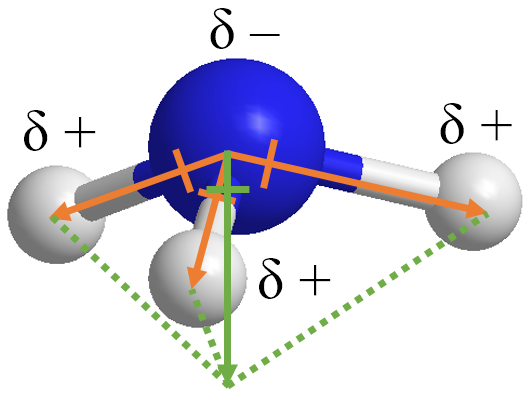

In [8]:
Image(filename="assets/num_dip_4.png", width=300)

上述图景也可以解释为，三个氢原子构成的正电中心与氮原子构成的负电中心产生了偶极。

<div class="alert alert-info">

**提醒**

化学中一般都会将偶极矩定义为从正电荷指向负电荷。这篇文档、以及量化程序所使用的定义是相反的 (可能是物理上定义的)，即负电荷指向正电荷。

我们刚才在程序中给出的偶极矩是沿 $z$ 轴向下的，这也符合上述图像的表述。

</div>

但该定义是基于无法确切定义的电正性、电负性所给出的。它的具体大小的计算，将不能依赖于上述图景。

<div class="alert alert-info">

**任务 (1)**

依据上述图景，讨论铵离子 ($\mathsf{NH_4^+}$) 的偶极矩。

</div>

### 点电荷相对于参考电荷的偶极矩

我们先讨论最为基础的问题。考虑只有两个点电荷的体系。我们认为，如果定义 $q_1$ 为参考电荷，则 $q_2$ 相对于 $q_1$ 所对偶极矩的贡献大小是 $\boldsymbol{d} = q_2 \boldsymbol{r}$，其中 $\boldsymbol{r}$ 是参考电荷 $q_1$ 指向电荷 $q_2$ 的长度矢量：

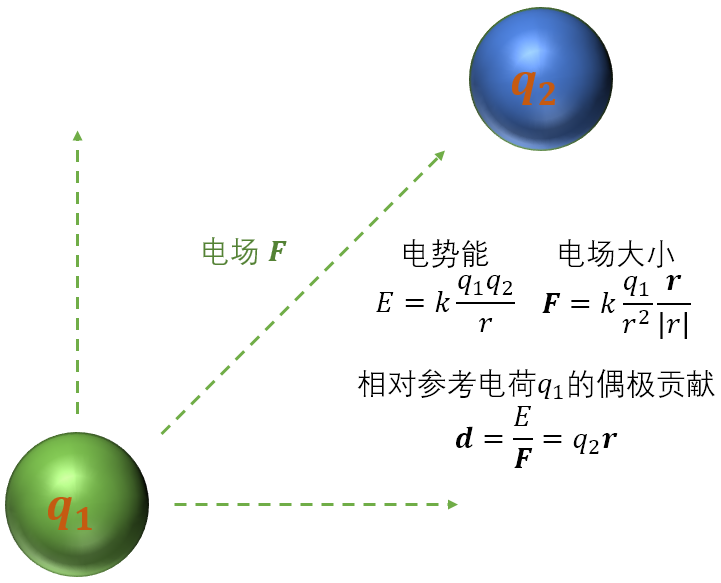

In [9]:
Image(filename="assets/num_dip_1.png", width=400)

通常来说，我们在讨论偶极矩时，会说只有 $q_1 = q_2$ 的对等偶极子情形时，才称之为偶极矩。因此，若要计算偶极矩，则需要先分别求出正负电荷中心，再求出电荷中心间距，从而乘以电荷得到偶极矩。

但在计算化学的分子时，正负电荷中心由于电子云本身的弥散性不易求；并且很有可能因为分子本身带电 (或分子的某个部分，譬如分子中原子核总是正电，电子云总是负电)，从而正负电荷量不能对等，不构成合理的偶极子。因此，在实际的计算中，我们并不强求 $q_1 = q_2$，而使用上图的定义来计算 $q_2$ 单个电荷的偶极矩贡献。

但这种定义方式可能相当奇怪。我们再回顾 $q_2$ 单个电荷的偶极计算过程：

$$
\boldsymbol{d} = q_2 \boldsymbol{r}
$$

我们发现：

- 偶极矩只与 $q_2$ 电荷的电量有关，而与参考电荷 $q_1$ 完全无关；

- 偶极矩与 $\boldsymbol{r}$ 有关，因此意味着参考电荷 $q_1$ 的位置也决定了偶极矩的大小。

这似乎与我们平时的认知不太相契合。我们一般总是认为，任何结构的偶极矩都是一个确定的、不随坐标平移而改变的量；但事实并非如此。我们下面来计算氨分子中原子核 (不包含电子云) 对偶极矩的贡献大小，来说明上述问题。

### 原子核对偶极矩的贡献

我们现在讨论方才定义的氨分子中，N 原子与 3 个 H 原子的原子核对偶极矩贡献。我们将原子核当作点电荷看待。下述矩阵的第 0 行是 N 原子的坐标，第 1, 2, 3 行是 H 原子的坐标 (单位 Bohr)。

In [10]:
A_t

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  1.88973, -0.94486],
       [ 1.63655, -0.94486, -0.94486],
       [-1.63655, -0.94486, -0.94486]])

今后我们始终假定参考电荷 (即上面提到的 $q_1$) 的坐标处在 $(0, 0, 0)$ 坐标点上 (电荷电量目前可以是任意的，但后文会作补充说明)。那么根据上面的表达式，可知对于每个原子，其所贡献的偶极矩贡献是：

$$
d_\mathrm{atom, A} = Z_A A_t
$$

In [11]:
np.einsum("A, At -> At", Z_A, A_t)

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  1.88973, -0.94486],
       [ 1.63655, -0.94486, -0.94486],
       [-1.63655, -0.94486, -0.94486]])

将上述的矩阵按列相加，就得到了总的原子对偶极矩作的贡献：

In [12]:
np.einsum("A, At -> t", Z_A, A_t)

array([ 0.     ,  0.     , -2.83459])

我们注意到，RHF 的偶极矩公式是 $d_t = - t_{\mu \nu} D_{\mu \nu} + Z_A A_t$，因此上面的过程就是求取了第二项 $Z_A A_t$。

但关于上述结果，我们需要作补充的说明。我们刚才讨论的情况如下图，参考电荷 (绿色圆点) 是在原点即氮原子 (蓝色圆点) 上：

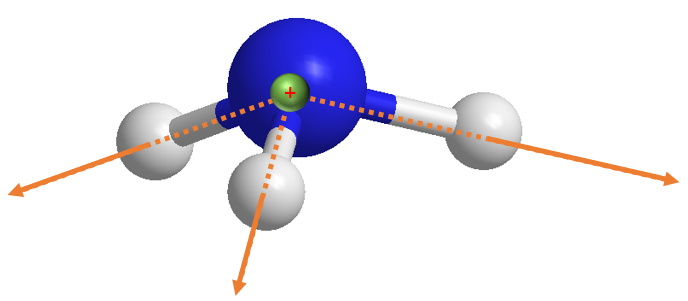

In [13]:
Image(filename="assets/num_dip_2.png", width=400)

但如果现在我们将分子下移而不更改参考电荷坐标，譬如我们降低氨分子 1 Angstrom，那么情形就会非常不一样：

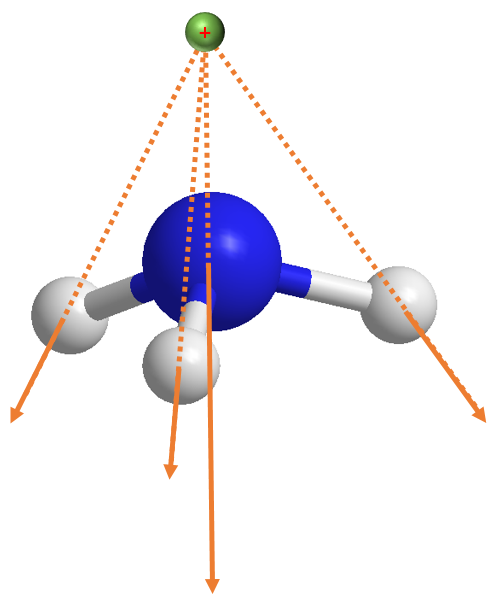

In [14]:
Image(filename="assets/num_dip_3.png", width=300)

我们定义该分子的 PySCF `gto.Mole` 实例是 `mol_m`：

In [15]:
mol_m = gto.Mole()
mol_m.atom = """
N  0.            0.  -1.
H  0.            1.  -1.5
H  0.8660254038 -0.5 -1.5
H -0.8660254038 -0.5 -1.5
"""
mol_m.basis = "6-31G"
mol_m.verbose = 0
mol_m.build()

我们注意到，分子的总偶极矩和对于这两个分子而言是相等的 (恰好因为氨分子是中性分子因此该结论成立)：

In [16]:
print("Dipole of original molecule: ", scf.RHF(mol).run().dip_moment())
print("Dipole of moved molecule:    ", scf.RHF(mol_m).run().dip_moment())

Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.55646
Dipole of original molecule:  [ 0.       0.      -2.55646]
Dipole moment(X, Y, Z, Debye): -0.00000,  0.00000, -2.55646
Dipole of moved molecule:     [-0.       0.      -2.55646]


但向下移动过的分子，其每个原子核对总偶极矩的贡献值并不同：

In [17]:
np.einsum("A, At -> At", mol_m.atom_charges(), mol_m.atom_coords())

array([[  0.     ,   0.     , -13.22808],
       [  0.     ,   1.88973,  -2.83459],
       [  1.63655,  -0.94486,  -2.83459],
       [ -1.63655,  -0.94486,  -2.83459]])

特别是我们注意到了氮原子：在没有移动的分子中，氮原子对总偶极矩的贡献是零值；但在向下移动后的分子中，氮原子产生了巨大的贡献。

相应地，向下移动过的分子的总原子核贡献也与未移动过的分子相差巨大：

In [18]:
np.einsum("A, At -> t", mol_m.atom_charges(), mol_m.atom_coords())

array([  0.     ,   0.     , -21.73185])

这部分差距将会在后面电子云的贡献有所补偿。

<div class="alert alert-info">

**提醒**

我们方才提到，分子总偶极矩可以拆分为原子核贡献项 $Z_A A_t$ 与电子云贡献项 $- t_{\mu \nu} D_{\mu \nu}$。这两项 **之和** 在分子为中性即不带正负电荷的情况下，是不受分子平移的影响而变化的。关于这点我们不作详细说明。

但需要注意，对于电荷并不平衡的 **离子** (例如铵离子 $\mathsf{MH_4^+}$)，量化计算所给出的偶极矩确实会 **受分子平移而变化**。关于离子是否有具有物理意义的偶极矩，暂还不在我们这篇文档的讨论范畴中。

</div>

<div class="alert alert-info">

**任务 (2)**

请使用 PySCF 的量化程序，给出铵离子 $\mathsf{NH_4^+}$ 偶极矩的大小。请问偶极矩大小是否受分子平移而变化？程序的结果是否支持任务 (1) 的结论？

</div>

### 电子云密度对偶极矩的贡献

我们再次回顾到对于点电荷 $q$ 单个电荷相对于参考电荷的偶极贡献为：

$$
\boldsymbol{d} = q \boldsymbol{r}
$$

但注意到这是点电荷的计算。对于电子弥散的电子云而言，我们有的是电子密度 `rho_0` $\rho(r)$。那么，我们对全空间的坐标微元 $\mathrm{d} \boldsymbol{r}$ 的电荷大小 $- \rho(r) \mathrm{d} \boldsymbol{r}$ 与 $\boldsymbol{r}$ 乘积的全积分：

$$
\boldsymbol{d} = - \int \rho(r) \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}
$$

之所以上式有负号，是因为作为电子，电荷是负的。

对上述连续空间的积分，我们很容易地想到可以离散我们用以前介绍过的方法生成氨分子的 (99, 590) 格点并生成密度，并作上述积分。

我们定义一些变量：

- `weights` $w_g$ 格点权重；

- `rho_0` $\rho_g$ 密度格点；

- `grid.coords` $t_g$ 格点坐标，但维度是 $(g, t)$ 即 (格点数量，三个坐标分量)。

In [19]:
grid = dft.Grids(mol)
grid.atom_grid = (99, 590)
grid.build()
gh = GridHelper(mol, grid, scf_eng.make_rdm1())
weights = grid.weights
rho_0 = gh.rho_0

那么，上述连续积分可以化为格点积分：

$$
d_t = - \int \rho(r) t \, \mathrm{d} \boldsymbol{r} = - w_g \rho_g t_g
$$

In [20]:
-(weights * rho_0 * grid.coords.T).sum(axis=1)

array([-0.    ,  0.    ,  1.8288])

这就是电子云对偶极矩的贡献了。将该贡献与上面的原子核坐标贡献相加，就能得到总分子的偶极矩了：

In [21]:
-(weights * rho_0 * grid.coords.T).sum(axis=1) + np.einsum("A, At -> t", Z_A, A_t)

array([-0.     ,  0.     , -1.00579])

可以看到，这与 PySCF 所给出的总偶极矩近乎于是相等的：

In [22]:
scf_eng.dip_moment(unit="A.U.")

Dipole moment(X, Y, Z, A.U.): -0.00000,  0.00000, -1.00579


array([-0.     ,  0.     , -1.00579])

但我们还需要注意到，上述的格点积分事实上上可以用解析积分替代。注意到

$$
d_t = - \int \rho(r) t \, \mathrm{d} \boldsymbol{r} = - \langle \mu | t | \nu \rangle D_{\mu \nu} = - t_{\mu \nu} D_{\mu \nu}
$$

上述公式也是在文段较早处已经实现过的：

In [23]:
- np.einsum("tuv, uv -> t", H_1_ao, D)

array([-0.    ,  0.    ,  1.8288])

同时，我们需要指出，如果分子的坐标发生平移，即使分子结构没有变化，电子云对偶极矩的贡献仍然是会变的；但与核坐标的贡献作加和，这部分变化就被抵消了。

## 偶极矩作为梯度计算量

我们事实上已经成功地推导出了 RHF 下的偶极矩了。但上述的推导在 XYG3 型泛函或 MP2 方法中，则会遇到问题：作为非变分的方法，如何定义电子云密度？

事实上这个问题并不是显然的，我们会放在以后讨论。既然不能轻松地给出电子云密度，那么就不能依据上述方式推导偶极矩。那么除了上述方式推导之外，还有什么方式可以获得偶极矩？我们可以通过对能量的电场梯度获得。

### 外加点电荷电场与分子构成的电势能

我们之前指出，对于处于原点的参考点电荷 $q_1$ 与点电荷 $q_2$，且前后者坐标所构成的向量是 $\boldsymbol{r}$；那么 $q_2$ 的偶极矩是通过 $q_1, q_2$ 形成的电势能 $E$ 与 $q_1$ 所散发的电场 $\boldsymbol{F}$ 的比值获得的：(这里的电势能 $E$ 有可能与后文的分子能量混淆，读者可能需要自行区分这两者)

$$
\boldsymbol{d} = \frac{E}{\boldsymbol{F}} = \frac{k q_1 q_2 / |r|}{k q_1 \boldsymbol{r} / |r|^3} = q_2 \boldsymbol{r}
$$

如果将点电荷 $q_2$ 换成氨分子，那么 $q_1$ 所散发的电场 $\boldsymbol{F}$ 仍然是已知的，但电荷与分子所构成的电势能在我们看来还并非是已知的。下面的目标将是生成参考电荷与氨分子所形成的电势能。

但直接计算电势能会比较困难；我们转而将参考点电荷所产生的额外电势能放到分子总能量中计算。我们指出，分子的 RHF 总能量计算包含 Hamiltonian Core 能量、J 积分、K 积分和核坐标互斥能。点电荷所产生的额外势能可以直接加到 Hamiltonian Core 中：

$$
\hat h = - \frac{1}{2} \nabla_\boldsymbol{r}^2 + \hat v_\mathrm{nuc} + \frac{\boldsymbol{F} \cdot \boldsymbol{d}}{\rho(\boldsymbol{r})}
$$ 

以该 Hamiltonian Core 代入自洽场计算中，就可以得到该分子在某种外电场 $\boldsymbol{F}$ 下的分子总能量了。将此能量减去不受外场微扰的分子总能量，就可以得到参考电荷 $q_1$ 下所产生的静电势能，并除以微扰电场 $\boldsymbol{F}$ 得到偶极矩了。

上式中分母部分的 $\rho(\boldsymbol{r})$ 表示氨分子密度；若对于点电荷情形，它接近于 $q_2$ 的意义。因此，

$$
\frac{\boldsymbol{F} \cdot \boldsymbol{d}}{\rho(\boldsymbol{r})} = \boldsymbol{F} \cdot \boldsymbol{r}
$$

这“某种”外场 $\boldsymbol{F}$ 原则上是任意的，我们之后认为分子的总能量 $E$ 是关于该外场的函数。我们现在就举一个具体的例子。现在我们假定 $\boldsymbol{F} = (0, 0, 10^{-4})$，那么该分子的能量可以通过如下方式求取：

In [24]:
scf_eng_p1 = scf.RHF(mol)
scf_eng_p1.get_hcore = lambda mol_: scf.rhf.get_hcore(mol_) - 1e-4 * mol_.intor("int1e_r")[2]
scf_eng_p1.run()
scf_eng_p1.e_tot

-56.13139652223548

上面的第二行代码是较为重要的代码：

- PySCF 的 Hamiltonian Core 是可以更改的，其默认函数签名是输入一个 `gto.Mole` 实例；因此，我们重新定义 `get_hcore` 为一个 lambda 函数；

- 其中，`scf.rhf.get_hcore` 是默认的 Hamiltonian Core，即动能部分与原子核静电吸引势部分；

- 负号是指参考电荷取正电荷，但电子云是负电荷，因此这就需要取负号；

- `1e-4` 表明外加电场强度是 $10^{-4}$；

- `mol_.intor("int1e_r")[2]` 代表的是 $\langle \mu | z | \nu \rangle$，即原子轨道在 $z$ 作为算符下的期望。之所以选用 $z$ 轴，是因为 $\boldsymbol{F} = (0, 0, 10^{-4})$ 中有值分量是 $z$ 轴分量；因此，$\boldsymbol{F} \cdot \boldsymbol{r} = 10^{-4} z$。

上面我们求出了在外场下的自洽场能量。我们注意到该能量与没有外电场的情况近乎一致，但有着细微的差别：

In [25]:
scf_eng.e_tot

-56.13157937104964

我们将两者能量的差近似为处于原点的参考电荷与分子共同产生的静电势能；将其除以外电场大小 $\boldsymbol{F}$ (的 $z$ 轴分量 $10^{-4}$)，就能得到 $z$ 轴分量的电子云偶极矩的近似值：

In [26]:
(scf_eng_p1.e_tot - scf_eng.e_tot) / 1e-4

1.8284881416263943

下面是解析计算所给出的电子云对偶极矩的贡献大小，我们会发现上面的计算结果非常接近下面的值：

In [27]:
- np.einsum("tuv, uv -> t", H_1_ao, D)[2]

1.8288017499152802

但需要留意，上面的过程很像三点差分，但实际上并非如此；因此，上面的计算精度尚还不够。下面我们就介绍如何使用三点差分计算偶极矩。

<div class="alert alert-info">

**任务 (3)**

我们刚才提到，我们假定的 $\boldsymbol{F}$ 的 $z$ 轴分量大小是 $10^{-4}$；它是用原子单位描述的，请指出其量纲。

</div>

### 三点差分计算偶极矩的电子云部分贡献

首先，我们指出，分子的能量可以写成受外加势场 $\boldsymbol{F}$ 的函数 $E(F_t)$，其中 $t$ 代表的是电场 $\boldsymbol{F}$ 的 $t$ 坐标分量。因此，实际上 $E(F_t)$ 表示的是一个关于 $t$ 的三维向量。

我们首先定义一个程序函数 `gen_eng_from_field`，它将输入坐标分量 $t$ `t` 与外电场 $F_t$ 的大小 (原子单位) `f`，输出在外场下的能量：

In [28]:
def gen_eng_from_field(t, f):
    mf = scf.RHF(mol)
    mf.get_hcore = lambda mol_: scf.rhf.get_hcore(mol_) - f * mol_.intor("int1e_r")[t]
    mf.run()
    return mf.e_tot

拿这个函数，我们可以重复刚才的能量值：

In [29]:
gen_eng_from_field(2, 1e-4)

-56.13139652223548

这是在 $F_z = 10^{-4}$ 的情况下。若 $F_z = -10^{-4}$，则体系能量为

In [30]:
gen_eng_from_field(2, -1e-4)

-56.131762282587246

我们回顾三点差分公式：

$$
f^\mathrm{d} (x, h) = \frac{f(x + h) - f(x - h)}{2h} \simeq f'(x)
$$

在这里，我们将 $x$ 看作是没有外加参考点电荷电场的情况即 $x = 0$，而 $h$ 是偏离零电场的场强 $F_z$。那么，电子云对偶极矩的 $z$ 轴方向的贡献值可以通过下述三点差分给出：

In [31]:
(gen_eng_from_field(2, 1e-4) - gen_eng_from_field(2, -1e-4)) / 2e-4

1.8288017592738015

类似地，我们也可以求出 $x$ 方向与 $y$ 方向电子云对偶极矩的贡献：

In [32]:
print("x: ", (gen_eng_from_field(0, 1e-4) - gen_eng_from_field(0, -1e-4)) / 2e-4)
print("y: ", (gen_eng_from_field(1, 1e-4) - gen_eng_from_field(1, -1e-4)) / 2e-4)

x:  -1.4210854715202004e-10
y:  -6.352252057695296e-08


可见对于氨分子而言，其电子云在 $x, y$ 轴方向上对偶极矩贡献为零。

### pyxdh 的偶极矩程序帮手

pyxdh 的程序自带了对偶极矩求导的部分。首先，我们构建偶极矩计算三点差分时所使用的所有计算实例的类 `DipoleDerivGenerator` 实例 `generator`。它的实例化需要一个函数，该函数的输入与之前提到的 `gen_eng_from_field` 一样，输入需要计算的偶极矩的坐标分量与外加电场强度。功能也类似，但一般来说返回的是计算对象为了便利期间，尽量不要是作为最终的能量。

In [33]:
def mf_func(t, f):
    mf = scf.RHF(mol)
    mf.get_hcore = lambda mol_: scf.rhf.get_hcore(mol_) - f * mol_.intor("int1e_r")[t]
    return mf.run()

generator = DipoleDerivGenerator(mf_func)

随后我们就像上一篇文档所述，用 `NumDiff` 类的实例 `diff` 来计算梯度：

In [34]:
diff = NumericDiff(generator, lambda mf: mf.e_tot)

In [35]:
diff.derivative

array([ 0.    , -0.    ,  1.8288])

但需要留意，上述的数值梯度只是电子云部分的贡献；全部偶极矩的贡献值是

In [36]:
diff.derivative + np.einsum("A, At -> t", Z_A, A_t)

array([ 0.     , -0.     , -1.00579])

## 参考任务解答

### 任务 (1)

铵离子的四个从氮原子到氢原子的偶极矢量之和为零，因此偶极矩为零。这会是通常的理解方式。具有非零偶极矩的分子应当是 $C_n, C_{nv}, C_s$ 点群。

但需要注意到，铵离子并非是中性分子。一般讨论偶极矩时，都要求结构处于中性，因此上述的讨论原则上是不正确的。

### 任务 (2)

我们可以定义一个 (未必是稳定构型) 铵离子，并计算其偶极矩。这个氨分子是 $T_d$ 对称的，并且需要将氮原子置于原点：

In [37]:
mol_NH4_0 = gto.Mole()
mol_NH4_0.atom = """
 N                 -0.00000000   -0.00000000    0.00000000
 H                 -0.00000000   -0.00000000    1.01098940
 H                 -0.00000000   -0.95316995   -0.33699647
 H                  0.82546939    0.47658497   -0.33699647
 H                 -0.82546939    0.47658497   -0.33699647
"""
mol_NH4_0.nelec = (5, 5)
mol_NH4_0.basis = "6-31G"
mol_NH4_0.verbose = 0
mol_NH4_0.build()
scf.RHF(mol_NH4_0).run().dip_moment(unit="A.U.")

Dipole moment(X, Y, Z, A.U.):  0.00000, -0.00000, -0.00000


array([ 0., -0., -0.])

我们会发现这个分子的偶极矩为零。但如果我们统一将离子沿 $z$ 轴下移 1 Angstrom，那么偶极矩就是非零了：

In [38]:
mol_NH4_1 = gto.Mole()
mol_NH4_1.atom = """
 N                 -0.00000000   -0.00000000   -1.00000000
 H                 -0.00000000   -0.00000000    0.01098940
 H                 -0.00000000   -0.95316995   -1.33699647
 H                  0.82546939    0.47658497   -1.33699647
 H                 -0.82546939    0.47658497   -1.33699647
"""
mol_NH4_1.nelec = (5, 5)
mol_NH4_1.basis = "6-31G"
mol_NH4_1.verbose = 0
mol_NH4_1.build()
scf.RHF(mol_NH4_1).run().dip_moment(unit="A.U.")

Dipole moment(X, Y, Z, A.U.):  0.00000, -0.00000, -1.88973


array([ 0.     , -0.     , -1.88973])

有意思的是，对于该分子的 $z$ 轴偶极矩，事实上它就是 1 Angstrom 换算成 Bohr 半径值的负值：这恰好与铵离子具有一个正电荷有关。

因此，这似乎与任务 (1) 的结论有所矛盾。一般来说，讨论离子的偶极矩可能是没有意义的。

### 任务 (3)

我们认为，$\hat h$ 应当具有能量的量纲，而 $\boldsymbol{r}$ 具有长度的量纲，因此 $\boldsymbol{F}$ 的量纲是能量除以长度。